## First benchmark

To benchmark: estimating disassembly indexes for increasing levels of complex peptidomes


        

In [38]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids


enzymes1 = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)

enzymes2 = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "K+R protease"),
    ],
    [1],
    [1],
)


enzymes3 = enzyme_set(
    [
        enzyme({"V": 0.3, "I": 0.3, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

In [39]:
protein = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"

In [40]:
from disassembly.simulate_proteolysis import simulate_proteolysis
from disassembly.estimate_weights import estimate_weights
from disassembly.disassembly import (
    get_disassembly,
    get_disassembly_indexes,
    get_disassembly_indexes_mc,
)

results = {}
test_names = ["simple", "medium", "complex", "random"]
iterations = 20
simulated_peptidomes = {}
simulated_graphs = {}
generated_graphs = {}

# Simulating peptidomes
for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    simulated_peptidomes[test_name] = {}
    simulated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(f"Running {test_name} {iteration}")
        simulated_peptidome, simulated_graph = simulate_proteolysis(
            protein,
            enzymes,
            n_start=3,
            n_generate=250,
            endo_or_exo_probability=[0.9, 0.1],
        )
        simulated_peptidomes[test_name][iteration] = simulated_peptidome
        simulated_graphs[test_name][iteration] = simulated_graph

# Running estimation
for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    results[test_name] = {}
    generated_graphs[test_name] = {}
    for iteration in range(iterations):
        results[test_name][iteration] = {}
        G, kls, generated, weights = estimate_weights(
            P=simulated_peptidomes[test_name][iteration],
            meta_enzyme=enzymes.meta_enzyme,
            exo_mult_factor=2,
            lr=1,
            n_iterations=1000,
            alpha=0.05,
        )
        generated_graphs[test_name][iteration] = G
        results[test_name][iteration]["kl"] = kls
        results[test_name][iteration]["rdi"] = get_disassembly_indexes_mc(
            simulated_graphs[test_name][iteration], 10000
        )
        results[test_name][iteration]["rd"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["rdi"],
        )
        results[test_name][iteration]["edi"] = get_disassembly_indexes_mc(G, 10000)
        results[test_name][iteration]["ed"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["edi"],
        )

Running simple 0
 249 / 250 (231)
130 unique peptides. 253 total
Running simple 1
 249 / 250 (237)
155 unique peptides. 253 total
Running simple 2
 249 / 250 (221)
127 unique peptides. 253 total
Running simple 3
 249 / 250 (231)
136 unique peptides. 253 total
Running simple 4
 249 / 250 (226)
131 unique peptides. 253 total
Running simple 5
 249 / 250 (229)
128 unique peptides. 253 total
Running simple 6
 249 / 250 (234)
108 unique peptides. 253 total
Running simple 7
 249 / 250 (229)
122 unique peptides. 253 total
Running simple 8
 249 / 250 (222)
155 unique peptides. 253 total
Running simple 9
 249 / 250 (235)
135 unique peptides. 253 total
Running simple 10
 249 / 250 (229)
144 unique peptides. 253 total
Running simple 11
 249 / 250 (233)
133 unique peptides. 253 total
Running simple 12
 249 / 250 (232)
137 unique peptides. 253 total
Running simple 13
 249 / 250 (229)
141 unique peptides. 253 total
Running simple 14
 249 / 250 (222)
125 unique peptides. 253 total
Running simple 15
 2

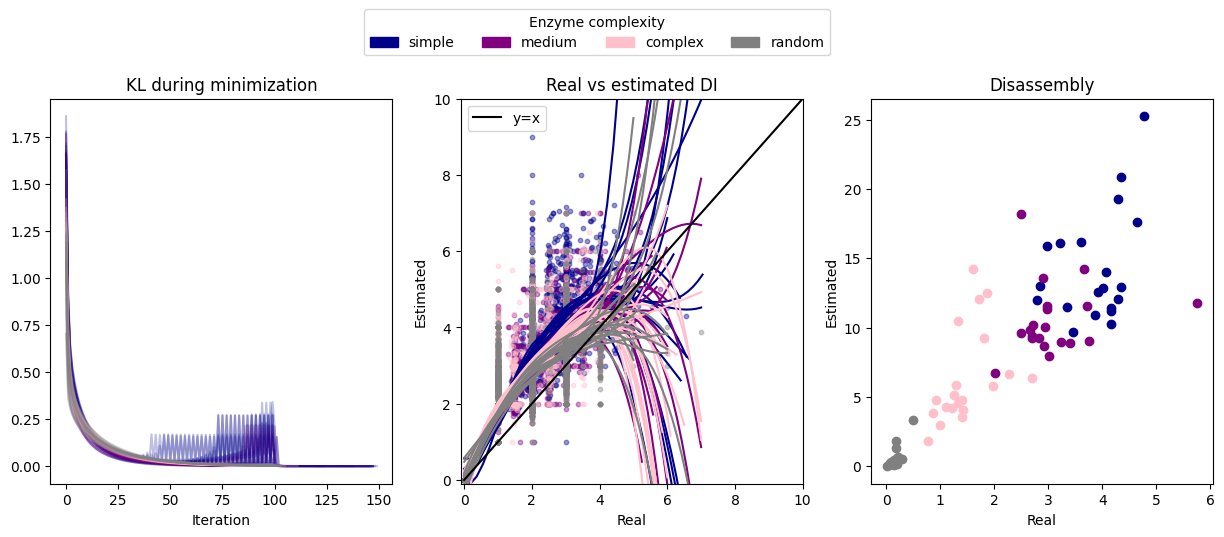

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from disassembly.util import get_nrmse

# Plotting KL-div
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ["darkblue", "purple", "pink", "gray"]

for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        axs[0].plot(
            results[test_name][iteration]["kl"],
            label=test_name,
            c=colors[i],
            alpha=0.25,
        )

# plotting corr DI
nrmse = {}
for i, test_name in enumerate(test_names):
    nrmse[test_name] = {}
    for iteration in range(iterations):
        real_di = results[test_name][iteration]["rdi"]
        estimated_di = results[test_name][iteration]["edi"]

        r_di = []
        e_di = []
        for sequence in real_di.keys():
            r_di.append(real_di[sequence])
            e_di.append(estimated_di[sequence])

        regress = np.polyfit(r_di, e_di, 4)

        axs[1].plot(
            np.linspace(0, max(e_di)),
            regress[0] * np.linspace(0, max(e_di)) ** 4
            + regress[1] * np.linspace(0, max(e_di)) ** 3
            + regress[2] * np.linspace(0, max(e_di)) ** 2
            + regress[3] * np.linspace(0, max(e_di))
            + regress[4],
            color=colors[i],
        )
        axs[1].scatter(r_di, e_di, c=colors[i], alpha=0.4, s=10)
        nrmse[test_name][iteration] = get_nrmse(r_di, e_di)

axs[1].plot(np.linspace(0, 50, 100), np.linspace(0, 50, 100), "black", label="y=x")
axs[1].legend()

# plotting real vs estimated disassembly
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        real_d = results[test_name][iteration]["rd"]
        estimated_d = results[test_name][iteration]["ed"]

        axs[2].scatter(real_d, estimated_d, color=colors[i])


axs[0].set_title("KL during minimization")
axs[0].set_xlabel("Iteration")
axs[1].set_title("Real vs estimated DI")
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[2].set_title("Disassembly")
axs[2].set_xlabel("Real")
axs[2].set_ylabel("Estimated")
axs[1].set_xlim([-.1, 10])
axs[1].set_ylim([-.1, 10])

import matplotlib.patches as mpatches

patches = []
for test_name, color in zip(test_names, colors):
    patches.append(mpatches.Patch(color=color, label=test_name))

plt.legend(
    handles=patches,
    bbox_to_anchor=(-0.1, 1.25),
    ncol=4,
    title="Enzyme complexity",
)

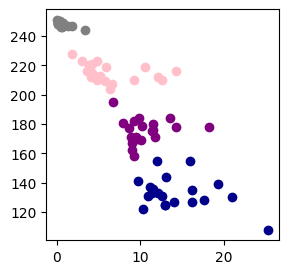

In [42]:
fig = plt.figure(figsize=(3, 3))
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        edi = results[test_name][iteration]["ed"]
        n_pep = len(simulated_peptidomes[test_name][iteration].keys())
        plt.scatter(edi, n_pep, c=colors[test_names.index(test_name)])

# Gradient descent

In [43]:
from disassembly.estimate_weights_gd import estimate_weights

for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    results[test_name] = {}
    generated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(test_name, iteration)
        results[test_name][iteration] = {}
        G, kls, generated, weights = estimate_weights(
            true_dict=simulated_peptidomes[test_name][iteration],
            lr=0.0005,
            n_iterations=500,
        )
        generated_graphs[test_name][iteration] = G
        results[test_name][iteration]["kl"] = kls
        results[test_name][iteration]["rdi"] = get_disassembly_indexes_mc(
            simulated_graphs[test_name][iteration], 10000
        )
        results[test_name][iteration]["rd"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["rdi"],
        )
        results[test_name][iteration]["edi"] = get_disassembly_indexes_mc(G, 10000)

        results[test_name][iteration]["ed"] = get_disassembly(
            simulated_peptidomes[test_name][iteration],
            results[test_name][iteration]["edi"],
        )

simple 0
 114 / 500 | 1.49, mean: 0.87 | Increasing | nz: 1011
Learning rate decreased to 0.00025
 499 / 500 | 0.67, mean: 0.67 | Plateau | nz: 1061075
 Averaged DI: 2.18

 Averaged DI: 2.70
simple 1
 107 / 500 | 1.14, mean: 0.99 | Increasing | nz: 1334
Learning rate decreased to 0.00025
 157 / 500 | 1.16, mean: 1.14 | Increasing | nz: 1333
Learning rate decreased to 0.000125
 499 / 500 | 0.98, mean: 0.98 | Plateau | nz: 1303287
 Averaged DI: 2.26

 Averaged DI: 2.89
simple 2
 103 / 500 | 0.73, mean: 0.72 | Increasing | nz: 785
Learning rate decreased to 0.00025
 499 / 500 | 0.61, mean: 0.61 | Plateau | nz: 769789
 Averaged DI: 2.08

 Averaged DI: 2.67
simple 3
 130 / 500 | 0.71, mean: 0.68 | Increasing | nz: 9898
Learning rate decreased to 0.00025
 499 / 500 | 0.58, mean: 0.58 | Plateau | nz: 9880002
 Averaged DI: 2.14

 Averaged DI: 2.73
simple 4
 99 / 500 | 1.85, mean: 2.02 | Increasing | nz: 1089
Learning rate decreased to 0.00025
 151 / 500 | 1.87, mean: 1.79 | Increasing | nz: 10

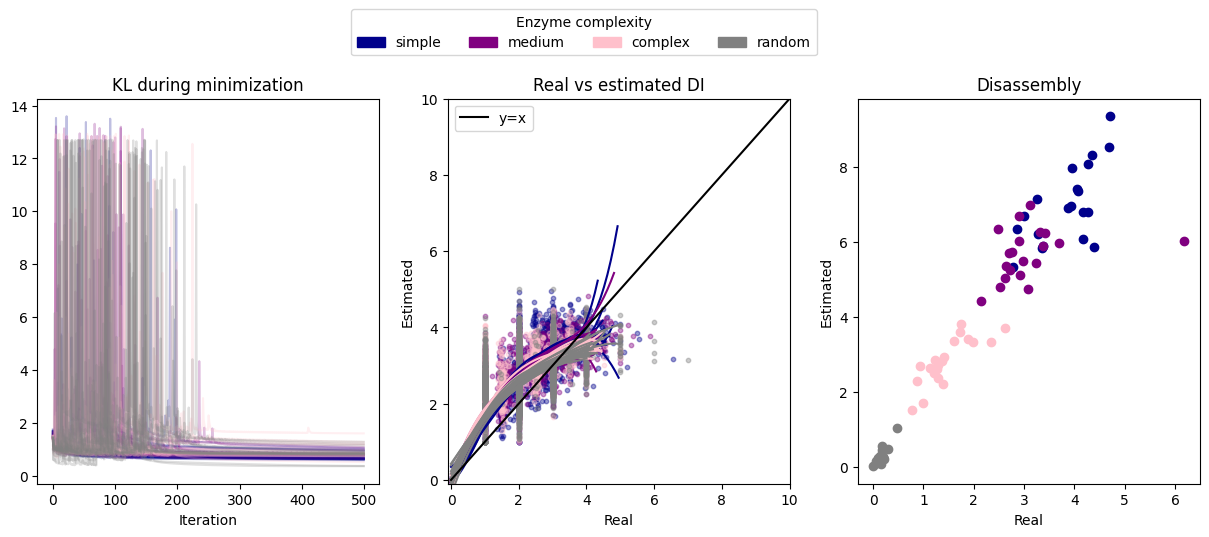

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from disassembly.util import get_nrmse

# Plotting KL-div
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ["darkblue", "purple", "pink", "gray"]

for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        axs[0].plot(
            results[test_name][iteration]["kl"],
            label=test_name,
            c=colors[i],
            alpha=0.25,
        )

# plotting corr DI
nrmse = {}
for i, test_name in enumerate(test_names):
    nrmse[test_name] = {}
    for iteration in range(iterations):
        real_di = results[test_name][iteration]["rdi"]
        estimated_di = results[test_name][iteration]["edi"]

        r_di = []
        e_di = []
        for sequence in real_di.keys():
            r_di.append(real_di[sequence])
            e_di.append(estimated_di[sequence])

        regress = np.polyfit(r_di, e_di, 4)

        axs[1].plot(
            np.linspace(0, max(e_di)),
            regress[0] * np.linspace(0, max(e_di)) ** 4
            + regress[1] * np.linspace(0, max(e_di)) ** 3
            + regress[2] * np.linspace(0, max(e_di)) ** 2
            + regress[3] * np.linspace(0, max(e_di))
            + regress[4],
            color=colors[i],
        )
        axs[1].scatter(r_di, e_di, c=colors[i], alpha=0.4, s=10)
        nrmse[test_name][iteration] = get_nrmse(r_di, e_di)

axs[1].plot(np.linspace(0, 12, 100), np.linspace(0, 12, 100), "black", label="y=x")
axs[1].legend()

# plotting real vs estimated disassembly
for i, test_name in enumerate(test_names):
    for iteration in range(iterations):
        real_d = results[test_name][iteration]["rd"]
        estimated_d = results[test_name][iteration]["ed"]

        axs[2].scatter(real_d, estimated_d, color=colors[i])


axs[0].set_title("KL during minimization")
axs[0].set_xlabel("Iteration")
axs[1].set_title("Real vs estimated DI")
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[2].set_title("Real (color) vs estimated (black) disassembly")
axs[2].set_title("Disassembly")
axs[2].set_xlabel("Real")
axs[2].set_ylabel("Estimated")
axs[1].set_xlim([-.1, 10])
axs[1].set_ylim([-.1, 10])

import matplotlib.patches as mpatches

patches = []
for test_name, color in zip(test_names, colors):
    patches.append(mpatches.Patch(color=color, label=test_name))

plt.legend(
    handles=patches,
    bbox_to_anchor=(-0.1, 1.25),
    ncol=4,
    title="Enzyme complexity",
)

# Peptidomes

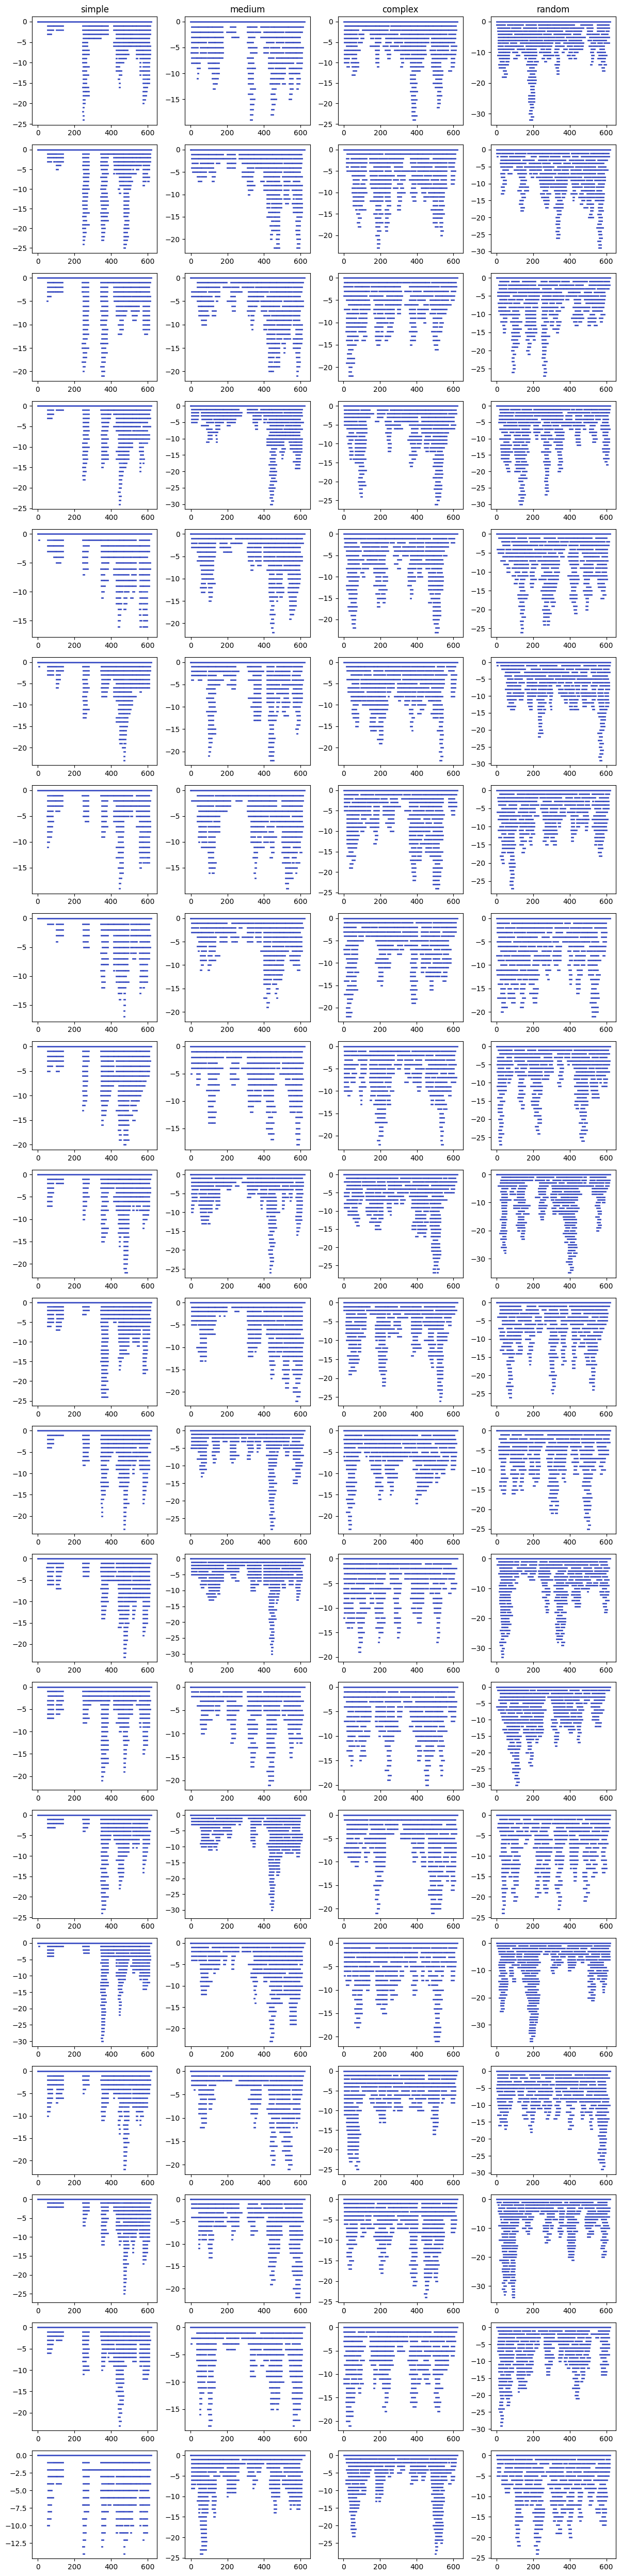

In [45]:
from disassembly.util import plot_peptidome

fig, axs = plt.subplots(
    iterations, len(test_names), figsize=(len(test_names) * 3, iterations * 2.5)
)
for iteration in range(iterations):
    for test_name in test_names:
        ax = axs[iteration, test_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()